In [2]:
from enum import Enum
import torch
import logging
import tqdm
import json
import os
import numpy as np
from dataset import RadarDataset
from model import UNet
from torch.utils.data import DataLoader
import torch.nn as nn
from runner import load_checkpoint, save_checkpoint, OptimizerChoice
from train import create_optimizer
from dotenv import load_dotenv
from common import get_scene
from encoder import Grid
import matplotlib.pyplot as plt
from config import label_to_index, CAR, LARGE_VEHICLE, BICYCLE, PEDESTRIAN, STATIC, DONT_CARE, final_labels, N_LABELS, label_to_str
from torchmetrics import ConfusionMatrix

load_dotenv()

%load_ext autoreload
%autoreload 2

In [20]:
n_sequences = np.arange(1, 158)
# n_sequences = np.arange(1, 50)
sequence_strs = [f"sequence_{i}" for i in n_sequences]

stats = {
    "sequence": [],
    "n_frames": [],
    "n_car": [],
    "n_static": [],
    "n_pedestrian": [],
    "n_bicycle": [],
    "n_large_vehicle": [],
    "rcs": [],
    "vr_compensated": [],
    # "rcs": {
    #     "min": 100,
    #     "max": -100
    # },
    # "vr_compensated": {
    #     "min": 100,
    #     "max": -100
    # }
}
for seq in tqdm.tqdm(sequence_strs):
    scene_fn = os.path.join(os.getenv("DATA_LOCATION"), seq, "scenes.json")
    detections = get_scene(scene_fn)
    stats["sequence"].append(seq)
    stats["n_frames"].append(detections['timestamp'].nunique())
    stats["n_car"].append(detections[detections['label_id'] == CAR].shape[0])
    stats["n_static"].append(detections[detections['label_id'] == STATIC].shape[0])
    stats["n_pedestrian"].append(detections[detections['label_id'] == PEDESTRIAN].shape[0])
    stats["n_bicycle"].append(detections[detections['label_id'] == BICYCLE].shape[0])
    stats["n_large_vehicle"].append(detections[detections['label_id'] == LARGE_VEHICLE].shape[0])
    # stats["rcs"] += detections['rcs'].tolist()
    # stats["vr_compensated"] += detections['vr_compensated'].tolist()
    # stats["rcs"]["min"] = min(stats["rcs"]["min"], detections['rcs'].min())
    # stats["rcs"]["max"] = max(stats["rcs"]["max"], detections['rcs'].max())
    # stats["vr_compensated"]["min"] = min(stats["vr_compensated"]["min"], detections['vr_compensated'].min())
    # stats["vr_compensated"]["max"] = max(stats["vr_compensated"]["max"], detections['vr_compensated'].max())


100%|██████████| 157/157 [00:44<00:00,  3.49it/s]


Text(0, 0.5, 'Frequency')

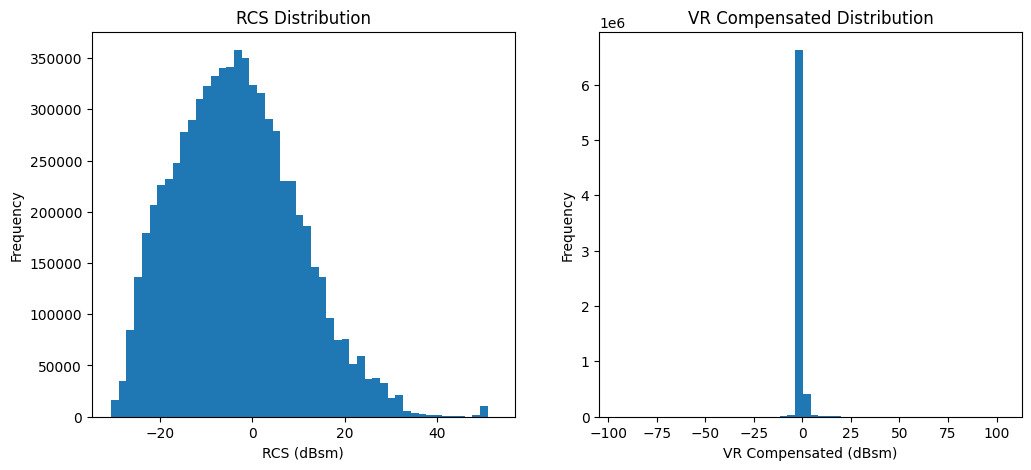

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(stats["rcs"], bins=50)
ax[0].set_title("RCS Distribution")
ax[0].set_xlabel("RCS (dBsm)")
ax[0].set_ylabel("Frequency")
ax[1].hist(stats["vr_compensated"], bins=50)
ax[1].set_title("VR Compensated Distribution")
ax[1].set_xlabel("VR Compensated (dBsm)")
ax[1].set_ylabel("Frequency")
fig.savefig("detection_stats.png")

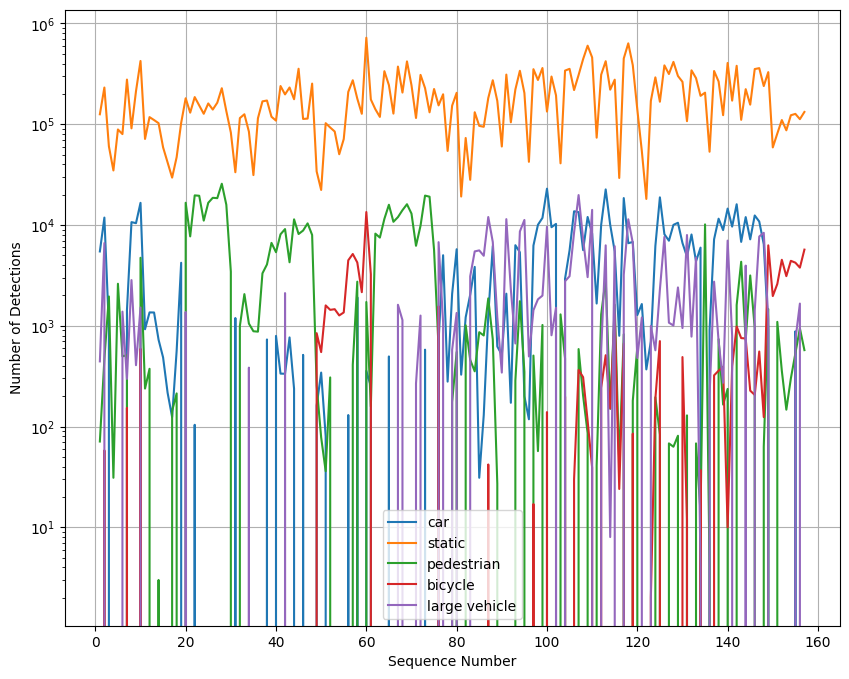

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_sequences, stats['n_car'], label='car')
ax.plot(n_sequences, stats['n_static'], label='static')
ax.plot(n_sequences, stats['n_pedestrian'], label='pedestrian')
ax.plot(n_sequences, stats['n_bicycle'], label='bicycle')
ax.plot(n_sequences, stats['n_large_vehicle'], label='large vehicle')
ax.grid(True)
ax.set_xlabel('Sequence Number')
ax.set_ylabel('Number of Detections')
ax.set_yscale('log')
ax.legend()
plt.show()

In [27]:
train_seq = [
    8,
    10,
    77,
    91,
    98,
    100,
    102,
    105,
    106,
    107,
    131,
    132,
    134,
    137,
    139,
    141,
    142,
    143,
    144,
    146,
    147,
    148,
]
val_seq = [2, 9, 101, 108]
car_static_ratio = np.array(stats['n_car']) / (np.array(stats['n_static']) + 1e-6)
pedestrian_static_ratio = np.array(stats['n_pedestrian']) / (np.array(stats['n_static']) + 1e-6)
bicycle_static_ratio = np.array(stats['n_bicycle']) / (np.array(stats['n_static']) + 1e-6)
lv_static_ratio = np.array(stats['n_large_vehicle']) / (np.array(stats['n_static']) + 1e-6)
np.argsort(-lv_static_ratio)

for n in train_seq:
    if n in val_seq:
        print(f"Sequence {n} is in both training and validation set!")
n_train_frames = sum([stats['n_frames'][i - 1] for i in train_seq])
n_val_frames = sum([stats['n_frames'][i - 1] for i in val_seq])
print(f"Number of training frames: {n_train_frames}")
print(f"Number of validation frames: {n_val_frames}")

Number of training frames: 34763
Number of validation frames: 6887


In [28]:
n_car = 0
n_static = 0
n_pedestrian = 0
n_bicycle = 0
n_large_vehicle = 0
for seq in train_seq:
    idx = stats["sequence"].index(f"sequence_{seq}")
    n_car += stats["n_car"][idx]
    n_static += stats["n_static"][idx]
    n_pedestrian += stats["n_pedestrian"][idx]
    n_bicycle += stats["n_bicycle"][idx]
    n_large_vehicle += stats["n_large_vehicle"][idx]
print("Training set class distribution:")
print(f"Car: {n_car}")
print(f"Static: {n_static}")
print(f"Pedestrian: {n_pedestrian}")
print(f"Bicycle: {n_bicycle}")
print(f"Large Vehicle: {n_large_vehicle}")

all_to_static_ratio = (n_car + n_pedestrian + n_bicycle + n_large_vehicle) / n_static
print(f"All to Static Ratio: {all_to_static_ratio:.3f}")

Training set class distribution:
Car: 219404
Static: 5445101
Pedestrian: 13339
Bicycle: 5654
Large Vehicle: 95113
All to Static Ratio: 0.061


In [31]:
from os import listdir


data_folder = "data/validation/input/"
gt_folder = "data/validation/gt/"
img_name_lists = listdir(data_folder)
gt_name_lists = listdir(gt_folder)
for img, gt in zip(img_name_lists, gt_name_lists):
    assert img == gt, f"Image and GT file names do not match: {img} != {gt}"

Running simulation...


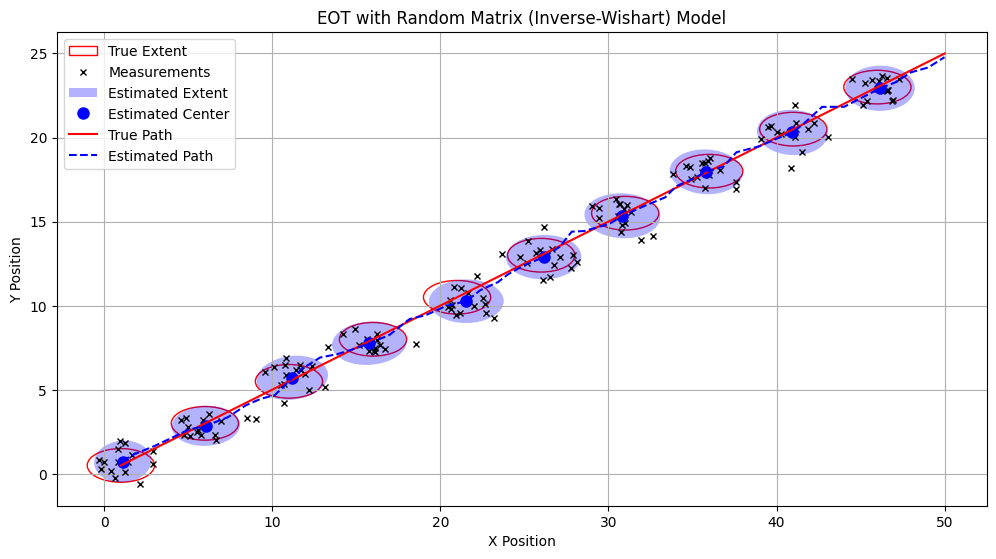

Done.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle

# --- Helper function to draw an error ellipse ---
def plot_covariance_ellipse(mean, cov, ax, **kwargs):
    """Plots an ellipse representing 2-sigma of the covariance matrix."""
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    # 2-sigma width/height
    width, height = 2 * 2 * np.sqrt(vals) 
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_artist(ell)
    return ell

# --- 1. Simulation Setup ---
dt = 1.0
timesteps = 50

# True object properties
true_width = 4.0
true_height = 2.0
# We represent the true extent as a covariance matrix
true_extent_matrix = np.diag([ (true_width/4)**2, (true_height/4)**2 ]) # (scaled for 2-sigma)

# True initial state [x, y, vx, vy]
true_state = np.array([0.0, 0.0, 1.0, 0.5])
true_states = []

# Sensor noise (this is the *sensor's* inherent noise, R_sensor)
sensor_noise_std = 0.5
R_sensor = np.diag([sensor_noise_std**2, sensor_noise_std**2])

# --- 2. Kinematic Filter Setup (Kalman Filter) ---
# State [x, y, vx, vy]
F = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
Q = np.diag([0.1, 0.1, 0.01, 0.01]) # Process noise

# Initial kinematic estimate
x_k = np.array([0.0, 0.0, 0.0, 0.0]) 
P_k = np.eye(4) * 10.0

# --- 3. Extent Filter Setup (Inverse-Wishart) ---
# The state is the 2x2 extent matrix X_k.
# We track its Inverse-Wishart (IW) distribution parameters:
# v = degrees of freedom (scalar)
# V = scale matrix (2x2)

v_k = 10.0  # Initial degrees of freedom (our confidence)
V_k = np.diag([2.0, 1.0]) # Initial scale matrix (our guess of the shape)

# Predict: Extent "forgets" over time (becomes more uncertain)
# This is a simple "decay" model for the degrees of freedom
extent_decay_rate = np.exp(-dt / 20.0) 

# Store estimates
estimated_kinematics = []
estimated_extents = []

# --- 4. Run the Simulation and Tracking ---
print("Running simulation...")
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, aspect='equal')

for t in range(timesteps):
    # --- 4a. Simulation (Ground Truth) ---
    true_state = F @ true_state
    true_states.append(true_state)
    true_center = true_state[:2]

    # Generate extended measurements
    num_measurements = 15
    # Measurements are sampled from a Gaussian with
    # covariance = (True Extent + Sensor Noise)
    total_measurement_cov = true_extent_matrix + R_sensor
    measurements = np.random.multivariate_normal(true_center, total_measurement_cov, num_measurements)
    
    # --- 4b. Predict (Kinematics) ---
    x_pred = F @ x_k
    P_pred = F @ P_k @ F.T + Q

    # --- 4c. Predict (Extent) ---
    # We predict the extent by "aging" the filter,
    # reducing its degrees of freedom (confidence).
    v_pred = extent_decay_rate * v_k
    V_pred = extent_decay_rate * V_k
    
    # The "best guess" for the extent matrix from the prediction is:
    X_pred = V_pred / (v_pred - 2 - 1) # Expected value of IW distribution

    # --- 4d. Process Measurements ---
    # In a real tracker, this is where you would cluster.
    # Here, we assume we have the correct cluster 'measurements'.
    
    z_centroid = np.mean(measurements, axis=0)
    
    # Calculate measurement spread (Scatter Matrix)
    Z_centered = measurements - z_centroid
    Z_scatter = Z_centered.T @ Z_centered

    # --- 4e. **THE COUPLING STEP** ---
    # Calculate the dynamic measurement noise (R_k)
    # The noise of the *centroid* is the object's extent
    # plus sensor noise, all divided by the number of measurements.
    
    R_k = (X_pred + R_sensor) / num_measurements

    # --- 4f. Update (Kinematics) ---
    # Use the dynamic R_k in the update
    y = z_centroid - H @ x_pred
    S = H @ P_pred @ H.T + R_k  # <-- R_k is used here!
    K = P_pred @ H.T @ np.linalg.inv(S)
    
    x_k = x_pred + K @ y
    P_k = (np.eye(4) - K @ H) @ P_pred

    # --- 4g. Update (Extent) ---
    # Update the Inverse-Wishart parameters
    v_k = v_pred + num_measurements
    V_k = V_pred + Z_scatter
    
    # Store results
    estimated_kinematics.append(x_k)
    # The best estimate for the extent is the expected value
    # of the posterior IW distribution
    X_k_est = V_k / (v_k - 2 - 1) 
    estimated_extents.append(X_k_est)

    # --- Plotting ---
    if t % 5 == 0:
        # Plot true object
        plot_covariance_ellipse(true_center, true_extent_matrix, ax, 
                                facecolor='none', edgecolor='red', 
                                label='True Extent' if t==0 else "")
        
        # Plot sensor measurements
        ax.plot(measurements[:, 0], measurements[:, 1], 'kx', 
                markersize=5, label='Measurements' if t==0 else "")
        
        # Plot estimated extent
        plot_covariance_ellipse(x_k[:2], X_k_est, ax, 
                                facecolor='blue', alpha=0.3, 
                                label='Estimated Extent' if t==0 else "")
        
        # Plot estimated center
        ax.plot(x_k[0], x_k[1], 'bo', 
                markersize=8, label='Estimated Center' if t==0 else "")

# --- Final Plotting ---
est_path = np.array(estimated_kinematics)
true_path = np.array(true_states)

ax.plot(true_path[:, 0], true_path[:, 1], 'r-', label='True Path')
ax.plot(est_path[:, 0], est_path[:, 1], 'b--', label='Estimated Path')

ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("EOT with Random Matrix (Inverse-Wishart) Model")
ax.legend()
ax.grid(True)
plt.show()

print("Done.")